# Notebook **Three** - How do the BCG-candidate spectroscopic redshifts compare to the original cluster redshifts?

This notebook contains everything necessary for you to work on the third step of this project - 
 
**Galaxy clusters** are single, gravitationally bound, objects made up of a **lot** of dark matter, quite a lot of hot gas (which is what emits X-rays), and the galaxies themselves (there are other components, but they don't matter right now).

**A BCG** is the most massive, brightest, galaxy in a cluster (though there can be multiple BCGs, or no obvious BCG at all).

**What will we get out of this stage of the project?**

* 

## Import statements and reading history/sample

In [1]:
from ident_run_setup import cosmo, side_length, HISTORY_FILE_PATH, load_history, proj_name, update_history

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

%matplotlib inline

The framework I've designed for this process (i.e. these notebooks) is trying to keep a useful history of the process - it has recorded the images that we were able to download or generate, and the BCG candidates you identified - here it will be keeping a record of the spectra you think are associated with each BCG candidate.

**This step will NOT produce an output csv file, as it isn't really a good format to store these results in (each BCG candidate can have multiple spectra, which doesn't really work in the 2D data storage of a csv) - as such to backup these results you should download the 'bcg_ident_proj_save.json' file, which is in the history directory.** 

In [2]:
cur_history = load_history()

Made a mistake in an earlier version of the spectral identification class, and the 6dF observation spectrum ID was just called 'spec_id' in the history, which clashes with some other headers when I'm constructing the multi-index dataframe below:

In [3]:
spec_ident = str(cur_history['bcg_spec_identification'])
if "'survey_spec_id': {'spec_id'" in spec_ident:
    spec_ident = spec_ident.replace("'survey_spec_id': {'spec_id'", "'survey_spec_id': {'obs_spec_id'")
    spec_ident = eval(spec_ident)
    cur_history['bcg_spec_identification'] = spec_ident
    update_history(cur_history)

We read the base **galaxy cluster** sample file into a Pandas dataframe - this contains the **original** redshifts for these clusters, which were derived from _photometric_ redshifts of member galaxies (so they aren't as accurate or reliable as the redshifts derived from the spectra you've identified):

In [4]:
# This reads the 'comma separated variable', or CSV/csv, file (which contains information about the sample of clusters
#  being investigated), from disk (on the hard-disk drive\HDD, or solid state disk\SSD) into memory (a much faster form of storage 
#  called Random Access Memory\RAM, where files being used by the operating system or currently running software live). We are using 
#  a Python module called 'Pandas' to read it in - think of it almost like a Python version of Excel
samp = pd.read_csv(cur_history['static_samp_file'])
# This means we can use .loc[ENTER NAME HERE] to get the information for a particular cluster
samp = samp.set_index('name')

# This method shows the top two lines of the loaded-in sample file
samp.head(2)

,cent_im_ra,cent_im_dec,redshift,r500,r500-,r500+,r2500,r2500-,r2500+,XCS_NAME,ang_prop_ratio
name,,,,,,,,,,,
SDSSXCS-124,0.800578,-6.091818,0.247483,1181.028159,21.202221,23.202641,534.834740,7.579124,7.591855,XMMXCS J000312.1-060530.5,232.859967
SDSSXCS-2789,0.955540,2.068019,0.105285,1007.860978,17.194150,17.201505,438.706515,5.198301,5.213676,XMMXCS J000349.3+020404.8,115.802997


## Putting the spectroscopic redshifts into a Pandas dataframe

Here we are taking the information on the BCG candidate spectra that you identified in the last step (which have been stored in the project history file), and putting it into an easier-to-interact with form - a Pandas dataframe.

Pandas is a Python module that you may have come across before (though don't be worried if you haven't), and is **extremely** popular in data-science (and science science). The main feature of Pandas is its 'dataframes', which you can think of as being similar to an Excel spreadsheet, but in Python - they are a great way of organising information that can be stored in a table, and can even read in files of a variety of common types (in the section above I use Pandas to read in a 'csv').

You don't have to read in an existing file to make a dataframe though, you can construct one in Python from (for instance) a numpy array, and a list of column names. 

Here I am building a dataframe from the project history, which is a big nested dictionary (a standard Python data structure) - this is a fairly complicated process, and isn't something a beginner would start with, so I'm not going to explain it properly here. **Just know that the Pandas dataframe I produce here is different from 'standard' dataframes, because it is 'multi-indexed' - this means that rather than being a simple table with one set of column names, the column names can have their own sub-columns (so the column 'BCG1' might have 'spec0', 'spec1', etc. sub-columns, because you identified several associated spectra).**

In [67]:
bcg_spec_rejig = [{'name': clust_name} | spec_info for clust_name, spec_info in cur_history['bcg_spec_identification'].items()]
spec_info = pd.json_normalize(bcg_spec_rejig)

rel_cols = spec_info.columns[(spec_info.columns == 'name') | spec_info.columns.str.contains(r'\.spec_id|z') | 
                              spec_info.columns.str.endswith('survey')]
spec_info = spec_info[rel_cols]
spec_info = spec_info.set_index('name')

spec_info.columns = pd.MultiIndex.from_tuples([tuple(col.split(".")) for col in spec_info.columns])
spec_info = spec_info.droplevel(1, axis=1)
spec_info.sort_index(axis=1, inplace=True)

## <span style="color:cyan">**YOU'RE FREE TO CHANGE EVERYTHING AFTER THIS!**</span>

## How can you access information from the dataframe?

The variable you need to use is 'spec_info' - if you type it in a Jupyter Notebook cell and run it (cmd+return on a Macbook), you'll be able to have a look at it. 

I've done just that in the cell below this one, and if you scroll the table to the right you should be able to see what I mean about each column having sub-columns (and even the sub-columns have sub-columns in this setup) - again this is **not** what a 'normal' (whatever that means) dataframe is like, they tend to just have one set of column names.

In [69]:
spec_info

BCG1                                                      \
                spec0                              spec1                    
              spec_id survey   z z_err z_quality spec_id survey   z z_err   
name                                                                        
SDSSXCS-124       NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   NaN   
SDSSXCS-2789      NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   NaN   
SDSSXCS-290       NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   NaN   
SDSSXCS-1018      NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   NaN   
SDSSXCS-134       NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   NaN   
...               ...    ...  ..   ...       ...     ...    ...  ..   ...   
SDSSXCS-2092      NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   NaN   
SDSSXCS-17923     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   NaN   
SDSSXCS-68        NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   NaN   
SDSSXCS-147       NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   NaN   
SDSSXCS-314       NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   NaN   

                                                                               \
                          spec2                              spec3              
              z_quality spec_id survey   z z_err z_quality spec_id survey   z   
name                                                                            
SDSSXCS-124         NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   
SDSSXCS-2789        NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   
SDSSXCS-290         NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   
SDSSXCS-1018        NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   
SDSSXCS-134         NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   
...                 ...     ...    ...  ..   ...       ...     ...    ...  ..   
SDSSXCS-2092        NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   
SDSSXCS-17923       NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   
SDSSXCS-68          NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   
SDSSXCS-147         NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   
SDSSXCS-314         NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   

                       BCG2                                                \
                      spec0                              spec1              
              z_err spec_id survey   z z_err z_quality spec_id survey   z   
name                                                                        
SDSSXCS-124     NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   
SDSSXCS-2789    NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   
SDSSXCS-290     NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   
SDSSXCS-1018    NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   
SDSSXCS-134     NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   
...             ...     ...    ...  ..   ...       ...     ...    ...  ..   
SDSSXCS-2092    NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   
SDSSXCS-17923   NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   
SDSSXCS-68      NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   
SDSSXCS-147     NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   
SDSSXCS-314     NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   

                                                          BCG3             \
                                spec2                    spec0              
              z_err z_quality spec_id survey   z z_err spec_id survey   z   
name                                                                        
SDSSXCS-124     NaN       NaN     NaN    NaN NaN   NaN     NaN    NaN NaN   
SDSSXCS-2789    NaN       NaN     NaN    NaN NaN   NaN     NaN    NaN NaN   
SDSSXCS-290     NaN       N

### Accessing data for specific clusters

Depending on how successful the spectrum identification process was, or if you started using the spectrum identification tool part way through the sample, you might see a lot of columns that just have 'NaN' in them - this stands for 'not a number', and is used throughout Pandas (and many other modules) as a 'null value'. Basically it indicates there is no information there. In other circumstances it might represent the result of a calculation that has no defined value (dividing something by zero for instance).

So, lets take a look at a cluster for which you know you identified some spectra (you're going to have change this yourself) - the way I set up this dataframe, you're going to be able to specify the **row** you're interested in by giving it the name of the cluster. **This won't be true of all dataframes, a lot of time you would need to specify the row number (also important to note is that Python uses 'zero-based' indexing, which means it starts counting at 0, so if you were using row numbers, the first row is row zero**).

We pass the name of the cluster to '.loc', which is for 'indexing' based on **labels** (e.g. rows with names rather than numbers, which is what I set up):

In [72]:
spec_info.loc['SDSSXCS-5939']

BCG1  spec0  spec_id      1031064.0
             survey            sdss
             z             0.171528
             z_err         0.000029
             z_quality          NaN
                            ...    
BCG4  spec1  z_quality          NaN
      spec2  spec_id            NaN
             survey             NaN
             z                  NaN
             z_err              NaN
Name: SDSSXCS-5939, Length: 67, dtype: object

Now you can see (if you have chosen a cluster that you **did** identify spectra for), that not everything is NaN! Bear in mind that you might not see _every_ column for the row you specified, as Pandas restricts how many it can show to avoid printing too much to the screen - you can tell if it has truncated what it is showing you by looking for the '...' ellipsis. 

What if we wanted to access more than one cluster (i.e. more than one row)? You use the same sort of command, but pass a list of cluster names:

In [74]:
spec_info.loc[['SDSSXCS-5939', 'SDSSXCS-5225']]

BCG1                                                  \
                  spec0                                           spec1   
                spec_id  survey         z     z_err z_quality   spec_id   
name                                                                      
SDSSXCS-5939  1031064.0    sdss  0.171528  0.000029       NaN       NaN   
SDSSXCS-5225  5022809.0  lamost  0.004039  0.000006       NaN  486332.0   

                                                                            \
                                                    spec2                    
             survey         z     z_err z_quality spec_id survey   z z_err   
name                                                                         
SDSSXCS-5939    NaN       NaN       NaN       NaN     NaN    NaN NaN   NaN   
SDSSXCS-5225   sdss  0.234806  0.000025       NaN     NaN    NaN NaN   NaN   

                                                      BCG2                   \
                         spec3                       spec0                    
             z_quality spec_id survey   z z_err    spec_id survey         z   
name                                                                          
SDSSXCS-5939       NaN     NaN    NaN NaN   NaN  1030842.0   sdss  0.171963   
SDSSXCS-5225       NaN     NaN    NaN NaN   NaN        NaN    NaN       NaN   

                                                                             \
                                   spec1                              spec2   
                 z_err z_quality spec_id survey   z z_err z_quality spec_id   
name                                                                          
SDSSXCS-5939  0.000026       NaN     NaN    NaN NaN   NaN       NaN     NaN   
SDSSXCS-5225       NaN       NaN     NaN    NaN NaN   NaN       NaN     NaN   

                                    BCG3                                       \
                                   spec0                                        
             survey   z z_err    spec_id survey         z     z_err z_quality   
name                                                                            
SDSSXCS-5939    NaN NaN   NaN  1030842.0   sdss  0.171963  0.000026       NaN   
SDSSXCS-5225    NaN NaN   NaN        NaN    NaN       NaN       NaN       NaN   

                                                                          \
               spec1                              spec2                    
             spec_id survey   z z_err z_quality spec_id survey   z z_err   
name                                                                       
SDSSXCS-5939     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   NaN   
SDSSXCS-5225     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   NaN   

                                                             BCG4             \
                         spec3                              spec0              
             z_quality spec_id survey   z z_err z_quality spec_id survey   z   
name                                                                           
SDSSXCS-5939       NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   
SDSSXCS-5225       NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   

                                                                         \
                               spec1                              spec2   
             z_err z_quality spec_id survey   z z_err z_quality spec_id   
name                                                                      
SDSSXCS-5939   NaN       NaN     NaN    NaN NaN   NaN       NaN     NaN   
SDSSXCS-5225   NaN       NaN     NaN    NaN NaN   NaN       NaN     NaN   

                               
                               
             survey   z z_err  
name                           
SDSSXCS-5939    NaN NaN   NaN  
SDSSXCS-5225    NaN NaN   NaN

### Accessing data for all clusters from specific columns

Accessing data for specific rows is very useful in many circumstances, but a lot of the time we want to do something with particular properties or pieces of information for every row in the table - in those cases it might be useful to be able to access, for instance, every redshift measured for every 'BCG1', without having to go through each cluster one by one.

This is operation is almost the inverse of accessing data for specific rows, and the syntax we use is nearly identical. Lets start with the simplest case - **you want** to get all the information for the 'BCG1' column (**and note that we don't have to use 'loc' for this simple case, as the dataframe assumes that indexes passed like this are column names, rather than the name of a row**):

In [78]:
spec_info['BCG1']

spec0                              spec1                   \
              spec_id survey   z z_err z_quality spec_id survey   z z_err   
name                                                                        
SDSSXCS-124       NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   NaN   
SDSSXCS-2789      NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   NaN   
SDSSXCS-290       NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   NaN   
SDSSXCS-1018      NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   NaN   
SDSSXCS-134       NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   NaN   
...               ...    ...  ..   ...       ...     ...    ...  ..   ...   
SDSSXCS-2092      NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   NaN   
SDSSXCS-17923     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   NaN   
SDSSXCS-68        NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   NaN   
SDSSXCS-147       NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   NaN   
SDSSXCS-314       NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   NaN   

                          spec2                              spec3             \
              z_quality spec_id survey   z z_err z_quality spec_id survey   z   
name                                                                            
SDSSXCS-124         NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   
SDSSXCS-2789        NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   
SDSSXCS-290         NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   
SDSSXCS-1018        NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   
SDSSXCS-134         NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   
...                 ...     ...    ...  ..   ...       ...     ...    ...  ..   
SDSSXCS-2092        NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   
SDSSXCS-17923       NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   
SDSSXCS-68          NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   
SDSSXCS-147         NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   
SDSSXCS-314         NaN     NaN    NaN NaN   NaN       NaN     NaN    NaN NaN   

                     
              z_err  
name                 
SDSSXCS-124     NaN  
SDSSXCS-2789    NaN  
SDSSXCS-290     NaN  
SDSSXCS-1018    NaN  
SDSSXCS-134     NaN  
...             ...  
SDSSXCS-2092    NaN  
SDSSXCS-17923   NaN  
SDSSXCS-68      NaN  
SDSSXCS-147     NaN  
SDSSXCS-314     NaN  

[150 rows x 19 columns]

If you compare what you see above to the table output at the beginning of the 'How can you access information from the dataframe?' section of this notebook, you should see that there is one fewer 'level' in the column names. The output we just produced doesn't have top-level column names of 'BCG1', 'BCG2', etc., as we have just selected **only** the 'BCG1' top-level column.

What if you wanted just the information about the first spectrum assigned to the BCG candidate? - _Also I realise the BCG numbering starts at one, and the spectrum numbering starts at zero - that was my mistake when designing this._ - Well, **we can just add another column name to our column indexing**:

In [79]:
spec_info['BCG1']['spec0']

,spec_id,survey,z,z_err,z_quality
name,,,,,
SDSSXCS-124,NaN,NaN,NaN,NaN,NaN
SDSSXCS-2789,NaN,NaN,NaN,NaN,NaN
SDSSXCS-290,NaN,NaN,NaN,NaN,NaN
SDSSXCS-1018,NaN,NaN,NaN,NaN,NaN
SDSSXCS-134,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
SDSSXCS-2092,NaN,NaN,NaN,NaN,NaN
SDSSXCS-17923,NaN,NaN,NaN,NaN,NaN
SDSSXCS-68,NaN,NaN,NaN,NaN,NaN


**And so on:**

In [80]:
spec_info['BCG1']['spec0']['z']

name
SDSSXCS-124     NaN
SDSSXCS-2789    NaN
SDSSXCS-290     NaN
SDSSXCS-1018    NaN
SDSSXCS-134     NaN
                 ..
SDSSXCS-2092    NaN
SDSSXCS-17923   NaN
SDSSXCS-68      NaN
SDSSXCS-147     NaN
SDSSXCS-314     NaN
Name: z, Length: 150, dtype: float64

However, we once again find ourselves focused in on a really specific set of values - except this time rather than being focused on one or two clusters/rows, we've focused on one measurement of redshift, specifically for the first spectrum associated with the first BCG candidate of a cluster. 

**What if we want to go a bit wider with our information? Say we wanted to compare the redshifts of the first spectrum associated with _each_ BCG candidate, to the existing redshifts of the input cluster sample (remember one of the reasons you've found all these spectra are to try and improve the existing redshifts of our clusters)!**

Well, we can use the same style of indexing the different levels of columns, but we avoid specifying the exact BCG candidate column - **instead we will give it ':', which just means 'all columns' in this context - because of where we pass ':', it really means _all top-level columns_**:

In [81]:
spec_info[:]['spec0']['z']

,z,z,z,z
name,,,,
SDSSXCS-124,NaN,NaN,NaN,NaN
SDSSXCS-2789,NaN,NaN,NaN,NaN
SDSSXCS-290,NaN,NaN,NaN,NaN
SDSSXCS-1018,NaN,NaN,NaN,NaN
SDSSXCS-134,NaN,NaN,NaN,NaN
...,...,...,...,...
SDSSXCS-2092,NaN,NaN,NaN,NaN
SDSSXCS-17923,NaN,NaN,NaN,NaN
SDSSXCS-68,NaN,NaN,NaN,NaN


In [59]:
zs = spec_info.loc(axis=1)[:, 'spec0', 'z'].values
og_zs = samp.loc[spec_info.index]['redshift'].values

## Now it's your turn...

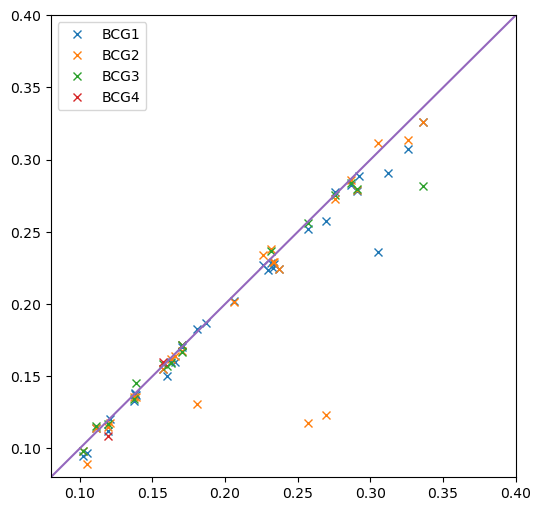

In [60]:
plt.figure(figsize=(6, 6))

plt.plot(og_zs, zs, 'x', label=['BCG1', 'BCG2', 'BCG3', 'BCG4'])
plt.plot([0.08, 0.4], [0.08, 0.4])
plt.xlim([0.08, 0.4])
plt.ylim([0.08, 0.4])

plt.legend()
plt.show()

In [35]:
boi.loc(axis=1)["BCG1", :, 'z']

BCG1                              
                  spec0     spec1     spec2     spec3
                      z         z         z         z
name                                                 
SDSSXCS-7432        NaN       NaN       NaN       NaN
SDSSXCS-11613       NaN       NaN       NaN       NaN
SDSSXCS-3           NaN       NaN       NaN       NaN
SDSSXCS-5939   0.171528       NaN       NaN       NaN
SDSSXCS-11881       NaN       NaN       NaN       NaN
SDSSXCS-11394  0.288675  0.288116       NaN       NaN
SDSSXCS-907    0.307181       NaN       NaN       NaN
SDSSXCS-14715  0.182427  0.182616       NaN       NaN
SDSSXCS-309    0.202103       NaN       NaN       NaN
SDSSXCS-457    0.277416  0.277501       NaN       NaN
SDSSXCS-35     0.278595       NaN       NaN       NaN
SDSSXCS-6      0.228337  0.228928  0.228170       NaN
SDSSXCS-176    0.155185       NaN       NaN       NaN
SDSSXCS-3672   0.326080       NaN       NaN       NaN
SDSSXCS-43     0.251958  0.252301  0.251852       NaN
SDSSXCS-32     0.137724  0.137713       NaN       NaN
SDSSXCS-16286  0.224006  0.223942       NaN       NaN
SDSSXCS-5527   0.138143       NaN       NaN       NaN
SDSSXCS-4313   0.290898       NaN       NaN       NaN
SDSSXCS-574    0.136939       NaN       NaN       NaN
SDSSXCS-65     0.170012       NaN       NaN       NaN
SDSSXCS-165    0.132853  0.132800       NaN       NaN
SDSSXCS-4003   0.159933       NaN       NaN       NaN
SDSSXCS-2836   0.096613  0.096571  0.096297       NaN
SDSSXCS-210    0.282305  0.282083       NaN       NaN
SDSSXCS-2288   0.257621       NaN       NaN       NaN
SDSSXCS-78     0.150130       NaN       NaN       NaN
SDSSXCS-55     0.111805  0.111695       NaN       NaN
SDSSXCS-137    0.094683       NaN       NaN       NaN
SDSSXCS-123    0.120705  0.120208       NaN       NaN
SDSSXCS-382    0.114302  0.113981       NaN       NaN
SDSSXCS-2282   0.035479       NaN       NaN       NaN
SDSSXCS-5624   0.235970       NaN       NaN       NaN
SDSSXCS-19     0.228001  0.227750       NaN       NaN
SDSSXCS-3312   0.187026  0.186999  0.186881  0.187167
SDSSXCS-575    0.227273  0.227282  0.227398       NaN
SDSSXCS-2      0.224627       NaN       NaN       NaN
SDSSXCS-30950       NaN       NaN       NaN       NaN
SDSSXCS-480    0.160145  0.160062       NaN       NaN
SDSSXCS-14     0.223263  0.222945  0.223456       NaN